In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-contrib-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

In [ ]:
try:
    from google.colab import drive
    print('Running on Google colab...')
    drive.mount('/content/drive') 
except:
    print('Running on local machine...')

Running on Google colab...
Mounted at /content/drive


In [ ]:
trainimages = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/images/*.jpg',shuffle=False)
testimages = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/test/images/*.jpg',shuffle=False)
valimages = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/val/images/*.jpg',shuffle=False)

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x) #read the file as bytes
    img = tf.io.decode_jpeg(byte_img) # convert to jpeg
    return img

In [ ]:
trainimages = trainimages.map(load_image) #map is used to apply the image_load function to every image path obtained from tensor flow
trainimages = trainimages.map(lambda x: tf.image.resize(x, (250,250)))
trainimages = trainimages.map(lambda x: x/255)

testimages = testimages.map(load_image)
testimages = testimages.map(lambda x: tf.image.resize(x, (250,250)))
testimages = testimages.map(lambda x: x/255)

valimages = valimages.map(load_image)
valimages = valimages.map(lambda x: tf.image.resize(x, (250,250)))
valimages = valimages.map(lambda x: x/255)

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

1/1 [==============================] - 15s 15s/step
Epoch 1/10
421/421 [==============================] - 963s 2s/step - loss: 0.7584 - val_loss: 0.1835
Epoch 2/10
421/421 [==============================] - 265s 629ms/step - loss: 0.0685 - val_loss: 0.1688
Epoch 3/10
421/421 [==============================] - 269s 639ms/step - loss: 0.0705 - val_loss: 0.1306
Epoch 4/10
421/421 [==============================] - 265s 629ms/step - loss: 0.0672 - val_loss: 0.0981
Epoch 5/10
421/421 [==============================] - 264s 626ms/step - loss: 0.0724 - val_loss: 0.0904
Epoch 6/10
421/421 [==============================] - 266s 633ms/step - loss: 0.0749 - val_loss: 0.0886
Epoch 7/10
421/421 [==============================] - 264s 627ms/step - loss: 0.0735 - val_loss: 0.1852
Epoch 8/10
421/421 [==============================] - 264s 626ms/step - loss: 0.0697 - val_loss: 0.0855
Epoch 9/10
421/421 [==============================] - 266s 631ms/step - loss: 0.0740 - val_loss: 0.0830
Epoch 10/10
421

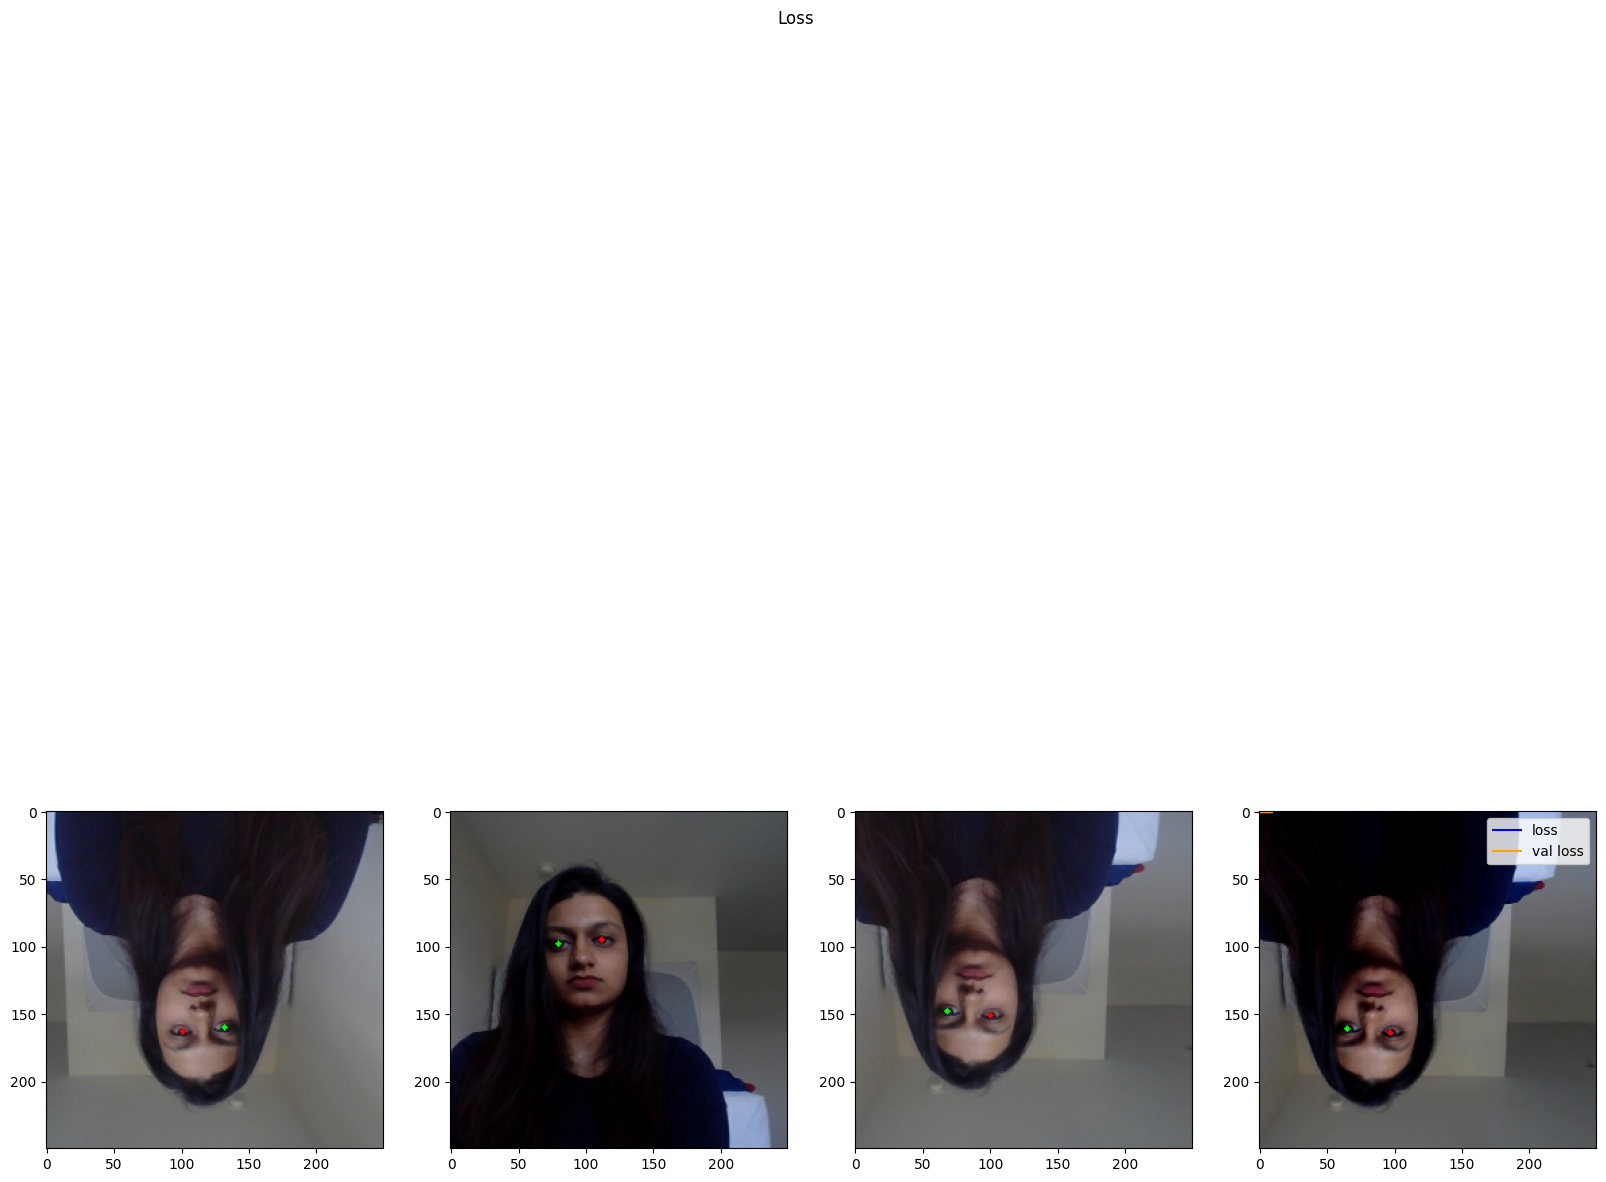

1/1 [==============================] - 0s 39ms/step


In [ ]:
trainlabels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/labels/*.json', shuffle=False)
trainlabels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

testlabels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/test/labels/*.json', shuffle=False)
testlabels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

vallabels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/val/labels/*.json', shuffle=False)
vallabels = vallabels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

train = tf.data.Dataset.zip((trainimages, trainlabels))
train = train.batch(16)
train = train.prefetch(4)

test = tf.data.Dataset.zip((testimages, testlabels))
test = test.batch(16)
test = test.prefetch(4)

val = tf.data.Dataset.zip((valimages, vallabels))
val = val.batch(16)
val = val.prefetch(4)

data_samples = train.as_numpy_iterator()

res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer, loss)

X, y = train.as_numpy_iterator().next()

scores = model.predict(X)

# Train for 10 epochs
hist = model.fit(train, epochs=10, validation_data=val)

plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.autoscale() 
plt.legend()
plt.show()

test_data = test.as_numpy_iterator()

test_sample = test_data.next()

yhat = model.predict(test_sample[0])

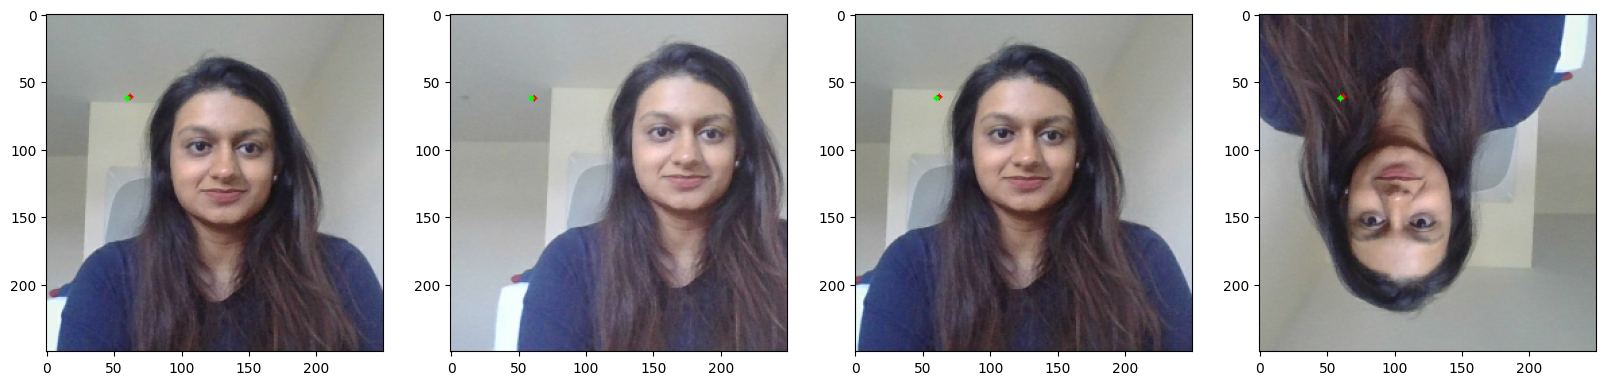

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

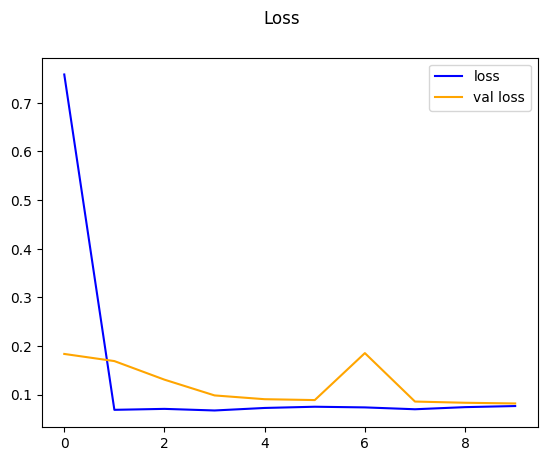

In [ ]:
hist.history
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.autoscale() 
plt.legend()
plt.show()

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
model.save('eyetrackerresnet.h5')
model = load_model('eyetrackerresnet.h5')
model.predict(test_sample[0])

1/1 [==============================] - 3s 3s/step


array([[0.25004613, 0.24854451, 0.24133602, 0.24988824],
       [0.25002015, 0.24829963, 0.240393  , 0.2495386 ],
       [0.2504338 , 0.24854673, 0.2413491 , 0.25008062],
       [0.25030553, 0.24735296, 0.24055713, 0.25087667],
       [0.25007367, 0.24800205, 0.2408437 , 0.24913356],
       [0.24993435, 0.24696444, 0.24040344, 0.2497784 ],
       [0.24995147, 0.24826242, 0.24078572, 0.24957226],
       [0.24966379, 0.24665123, 0.2401616 , 0.24877794],
       [0.25047597, 0.24764952, 0.24053119, 0.25002956],
       [0.24989593, 0.24825482, 0.24023366, 0.24926677],
       [0.2500169 , 0.24770848, 0.24033728, 0.2484862 ],
       [0.24955024, 0.24683347, 0.24208352, 0.25079188],
       [0.24792239, 0.24764334, 0.24166547, 0.2495652 ],
       [0.24971555, 0.24711505, 0.24050339, 0.25109887],
       [0.24996701, 0.24719174, 0.24052277, 0.25034237],
       [0.24964768, 0.2476273 , 0.24050257, 0.24928524]], dtype=float32)